In [ ]:
!pip install --upgrade git+https://github.com/VincentStimper/normalizing-flows.git

  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-qoz245_f
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-qoz245_f
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-vs8z60bp/residual-flows_333bb6c7b4c149cfa645dfe710ae572a
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-vs8z60bp/residual-flows_333bb6c7b4c149cfa645dfe710ae572a
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=407596c3ab0c1d109aed56623a5d62d8f0ca74db8d748be28dfabedc166fc263
  Stored in directory: /tmp/pip-ephem-wheel-cache-p7vrvdrg/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=725f6688f031689ec3c6ca4901e8d91ace8b8edfaec73bcacd2eb54348455c9f
  Stored in directory: /tmp/pip-ephem-wh

In [ ]:
import numpy as np
import torch
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

# For saving and loading
import pickle
%matplotlib inline

In [ ]:
K = 6
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
  )
)

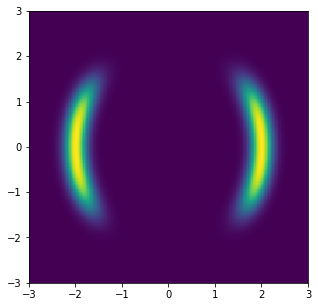

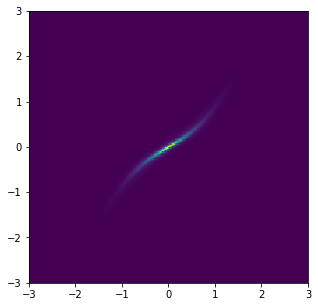

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

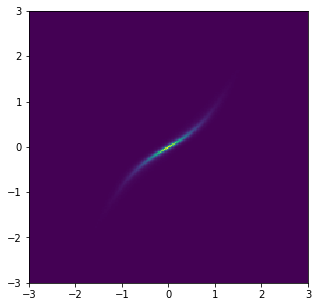

  0%|          | 1/20000 [00:00<1:58:00,  2.82it/s]

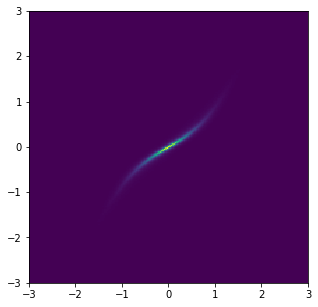

  0%|          | 2/20000 [00:00<1:55:34,  2.88it/s]

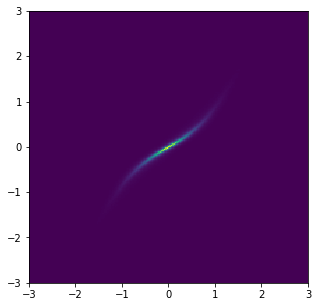

  0%|          | 3/20000 [00:01<1:53:51,  2.93it/s]

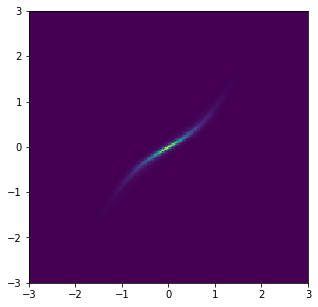

  0%|          | 4/20000 [00:01<1:55:10,  2.89it/s]

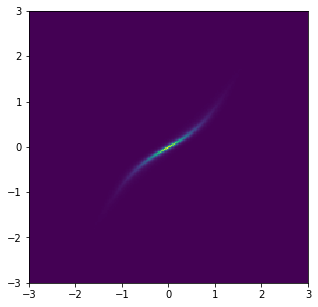

 10%|▉         | 1993/20000 [00:30<04:31, 66.38it/s]

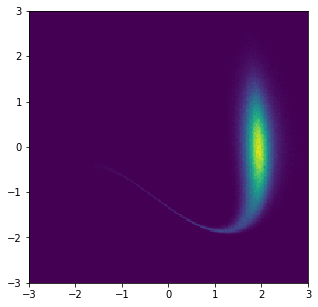

 20%|█▉        | 3998/20000 [01:00<03:57, 67.51it/s]

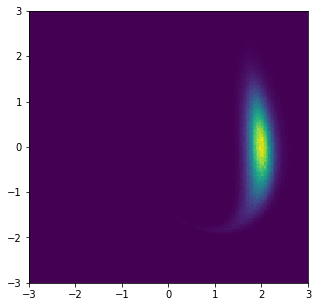

 30%|██▉       | 5998/20000 [01:30<03:28, 67.25it/s]

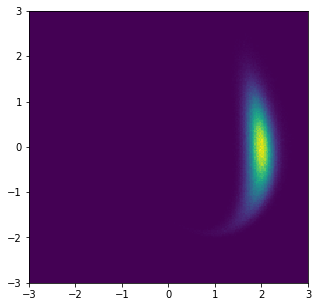

 40%|███▉      | 7999/20000 [01:59<02:53, 69.23it/s]

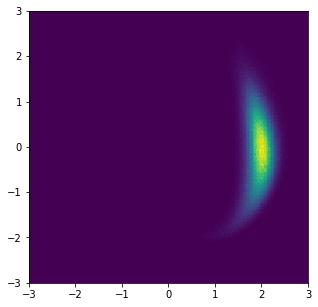

 50%|████▉     | 9995/20000 [02:29<02:23, 69.76it/s]

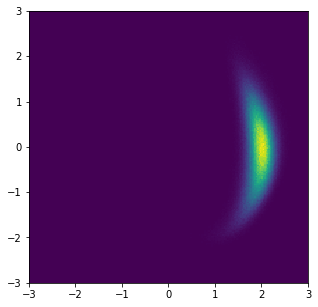

 60%|█████▉    | 11994/20000 [02:59<02:00, 66.37it/s]

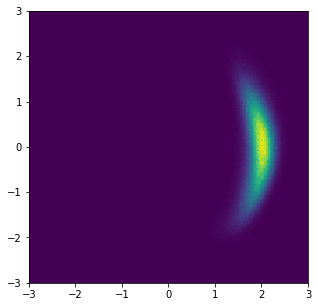

 70%|██████▉   | 13996/20000 [03:28<01:29, 67.39it/s]

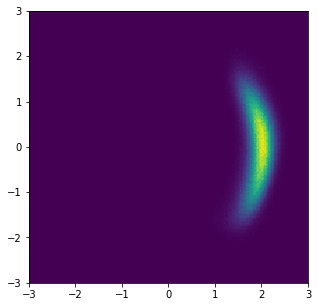

 80%|███████▉  | 15999/20000 [03:59<01:02, 63.75it/s]

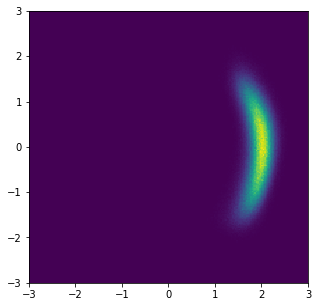

 90%|████████▉ | 17998/20000 [04:29<00:30, 66.07it/s]

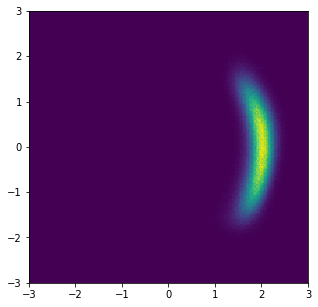

100%|█████████▉| 19999/20000 [04:59<00:00, 67.98it/s]

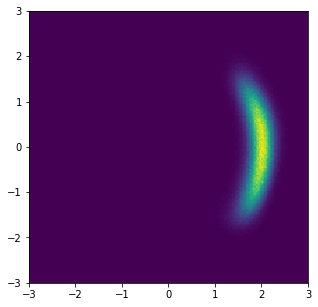

100%|██████████| 20000/20000 [05:00<00:00, 66.63it/s]


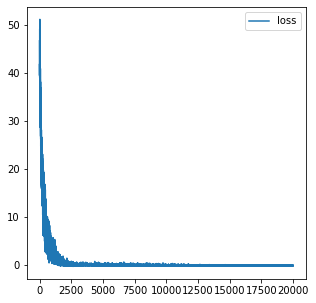

In [ ]:
# Train model
max_iter = 20000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = nfm.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if (it < 5) | ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = nfm.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

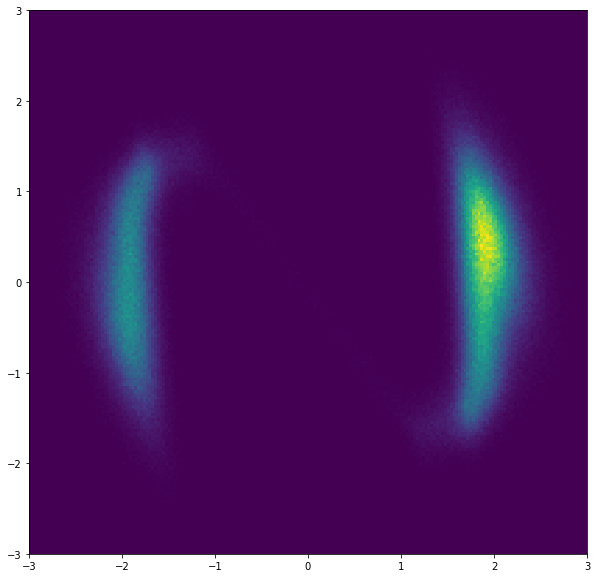

In [ ]:
# Plot learned posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Architecture of NF model

In [ ]:
x = gst[0][:2, 0]
y = gst[0][:2, 1]
z = gst[0][:2, 2]

for triangle in gst:
    x = np.append(x, triangle[2, 0])
    y = np.append(y, triangle[2, 1])
    z = np.append(z, triangle[2, 2])

target_coords = np.hstack((x[:,None],y[:,None],z[:,None]))
rot_mats = []

for rotation in rot:
    r = R.from_euler('zyz', rotation)
    rot_mats.append(r.as_matrix())

z0 = target_coords + np.random.multivariate_normal([0,0,0], (q/5)*np.eye(3), 102)
print(z0.shape)
print(len(rot_mats))

print(np.linalg.norm(z0 - target_coords))
print(imgs[567].sum())

(102, 3)
1000
61.61205692369596
4.2495970391664954


In [ ]:
class architecture(nn.Module):
    def __init__(self, Q=q, scale=10.0, n_cells=51, template=torch.tensor(z0, dtype=torch.float)):
        super().__init__()
        self.Q = q
        self.scale = scale
        self.n_cells = n_cells
        self.template = template

        axes_coord = np.linspace(-q, q, num=n_cells)
        x,y = np.meshgrid(axes_coord, axes_coord)
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x
        pos[:, :, 1] = y
        self.image_mat = torch.tensor(pos, dtype=torch.double)

        self.mlp = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def gaussian_blobs(self, coord_list):
        #volume = torch.zeros_like(self.volume_mat[:,:,:,0])
        image = torch.zeros_like(self.image_mat[:,:,0])

        for coord in coord_list:
            #m = torch.distributions.multivariate_normal.MultivariateNormal(coord.type(torch.double),\
            #                                (self.scale/3)*torch.eye(3, dtype=torch.double))
            #volume = volume + m.log_prob(self.volume_mat).exp()
            m = torch.distributions.multivariate_normal.MultivariateNormal(coord[:2].type(torch.double),\
                                            (self.scale/3)*torch.eye(2, dtype=torch.double))
            image = image + m.log_prob(self.image_mat).exp()

        return image/(2*self.Q/self.n_cells)#, volume.sum(axis=2) 
    

    def forward(self, rotmat_list):
        new_coords = self.template + self.mlp(self.template)
        recons_imgs = []
        for rot in rotmat_list:
            rotated_coords = torch.mm(new_coords, torch.tensor(rot, dtype=torch.float).T)
            #print(len(recons_imgs))
            recons_img = self.gaussian_blobs(rotated_coords)
            recons_imgs.append(recons_img)
        
        return torch.stack(recons_imgs)

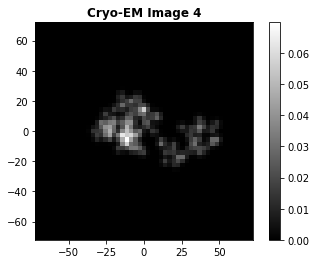

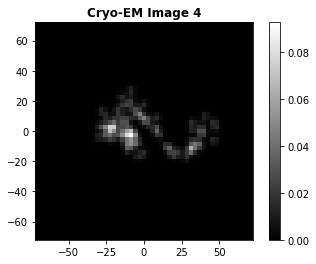

torch.Size([1, 51, 51])


In [ ]:
model = architecture()
recons_imgs = model([rot_mats[0]])

c = plt.imshow(recons_imgs[0].detach().numpy(), cmap ='gray', vmin = 0, vmax = np.abs(recons_imgs[0].detach().numpy()).max(),\
                extent = [-q, q, -q, q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)
                
plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
plt.show()

c = plt.imshow(torch_imgs[0].detach().numpy(), cmap ='gray', vmin = 0, vmax = np.abs(torch_imgs[0].detach().numpy()).max(),\
                extent = [-q, q, -q, q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)
                
plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
plt.show()

print(recons_imgs.shape)

In [ ]:
a=model([rot_mats[0]])[0]
b=torch_imgs[0]
print(criterion(a,b))

tensor(1.6238e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [ ]:
model = architecture()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    i = 0 
    for rot_mat, target_img in zip(rot_mats, torch_imgs):
        recon = model([rot_mat])
        loss = criterion(recon[0], target_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i=i+1

        if i%50 == 0:
            print(f'Epoch:{epoch+1}, Loss:{loss.item()}')

Epoch:1, Loss:1.9130571264308374e-05
Epoch:1, Loss:2.3830722367089028e-05
Epoch:1, Loss:1.4948111366042532e-05
Epoch:1, Loss:1.5250960324488013e-05
Epoch:1, Loss:2.345306127621371e-05
Epoch:1, Loss:2.0132411599717332e-05
Epoch:1, Loss:2.3703017018829227e-05
Epoch:1, Loss:2.4435055650421814e-05
Epoch:1, Loss:2.326659384565578e-05
Epoch:1, Loss:2.3335944864033032e-05
Epoch:1, Loss:2.119550922283887e-05
Epoch:1, Loss:2.009225242538717e-05
Epoch:1, Loss:2.266542539491422e-05
Epoch:1, Loss:2.345578258483707e-05
Epoch:1, Loss:2.0871333588038978e-05
Epoch:1, Loss:2.5813728896137524e-05
Epoch:1, Loss:2.089238471235918e-05
Epoch:1, Loss:2.0224730698052647e-05
Epoch:1, Loss:2.5131010578058165e-05
Epoch:1, Loss:2.335151938096205e-05
Epoch:2, Loss:1.989441490585278e-05
Epoch:2, Loss:2.682936762441815e-05
Epoch:2, Loss:1.5854987871815364e-05
Epoch:2, Loss:1.5957558817843107e-05
Epoch:2, Loss:2.457625456656723e-05
Epoch:2, Loss:2.0682267505123307e-05
Epoch:2, Loss:2.412468274687738e-05
Epoch:2, Loss

KeyboardInterrupt: ignored

# Testing right side of pipeline

In [ ]:
def gaussian_blobs(coord_list, n_cells=51):
    image = torch.zeros((n_cells, n_cells))
    axes_coord = np.linspace(-q, q, num=n_cells)
    x,y = np.meshgrid(axes_coord, axes_coord)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    image_mat = torch.tensor(pos, dtype=torch.double)

    for coord in coord_list:
        m = torch.distributions.multivariate_normal.MultivariateNormal(coord[:2].type(torch.double),\
                                                        (10.0/3)*torch.eye(2, dtype=torch.double))
        image = image + m.log_prob(image_mat).exp()

    return image/(2*q/n_cells)

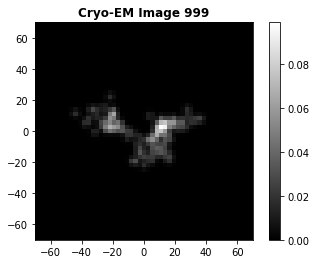

In [ ]:
"""
img_list = []

for i in range(len(imgs)):
    conformation = atmcrd[i] #possc[conf[i]]
    rotation = rot[i]

    x = conformation[0][:2, 0]
    y = conformation[0][:2, 1]
    z = conformation[0][:2, 2]

    for triangle in conformation:
        x = np.append(x, triangle[2, 0])
        y = np.append(y, triangle[2, 1])
        z = np.append(z, triangle[2, 2])

    target_coords = np.hstack((x[:,None],y[:,None],z[:,None]))
    r = R.from_euler('zyz', rotation)
    rot_mat = r.as_matrix()

    rotated_coords = torch.mm(torch.tensor(target_coords, dtype=torch.float), torch.tensor(rot_mat, dtype=torch.float).T)

    img_aliter = gaussian_blobs(rotated_coords)
    img_list.append(img_aliter)

print(len(img_list))"""

c = plt.imshow(np.abs(img_list[0]), cmap ='gray', vmin = 0, vmax = np.abs(img_list[0]).max(),\
                extent = [-q, q, -q, q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)
                
plt.title(f'Cryo-EM Image {i}', fontweight = "bold")
plt.show()

In [ ]:
for i in range(len(img_list)):
    mse_list = []
    for conformation in possc:
        rotation = rot[i]

        x = conformation[0][:2, 0]
        y = conformation[0][:2, 1]
        z = conformation[0][:2, 2]

        for triangle in conformation:
            x = np.append(x, triangle[2, 0])
            y = np.append(y, triangle[2, 1])
            z = np.append(z, triangle[2, 2])

        target_coords = np.hstack((x[:,None],y[:,None],z[:,None]))
        r = R.from_euler('zyz', rotation)
        rot_mat = r.as_matrix()

        rotated_coords = torch.mm(torch.tensor(target_coords, dtype=torch.float), torch.tensor(rot_mat, dtype=torch.float).T)
        img_aliter = gaussian_blobs(rotated_coords)
        mse_list.append(torch.linalg.norm(img_aliter - img_list[i]))

    print([torch.argmin(torch.tensor(mse_list)), conf[i]])

[tensor(7), 7]
[tensor(2), 2]
[tensor(5), 5]
[tensor(4), 4]
[tensor(0), 0]
[tensor(5), 5]
[tensor(6), 6]
[tensor(8), 8]
[tensor(3), 3]
[tensor(7), 7]
[tensor(9), 9]
[tensor(4), 4]
[tensor(2), 2]
[tensor(8), 8]
[tensor(0), 0]
[tensor(1), 1]
[tensor(0), 0]
[tensor(1), 1]
[tensor(0), 0]
[tensor(9), 9]
[tensor(8), 8]
[tensor(9), 9]
[tensor(6), 6]
[tensor(5), 5]
[tensor(2), 2]
[tensor(6), 6]
[tensor(8), 8]
[tensor(4), 4]
[tensor(6), 6]
[tensor(1), 1]
[tensor(2), 2]
[tensor(3), 3]
[tensor(9), 9]
[tensor(9), 9]
[tensor(2), 2]
[tensor(8), 8]
[tensor(9), 9]
[tensor(4), 4]
[tensor(5), 5]
[tensor(0), 0]
[tensor(9), 9]
[tensor(5), 5]
[tensor(3), 3]
[tensor(7), 7]
[tensor(2), 2]
[tensor(1), 1]
[tensor(2), 2]
[tensor(1), 1]
[tensor(7), 7]
[tensor(9), 9]
[tensor(9), 9]
[tensor(2), 2]
[tensor(4), 4]
[tensor(3), 3]
[tensor(6), 6]
[tensor(1), 1]
[tensor(7), 7]
[tensor(4), 4]
[tensor(0), 0]
[tensor(0), 0]
[tensor(9), 9]
[tensor(0), 0]
[tensor(2), 2]
[tensor(7), 7]
[tensor(1), 1]
[tensor(5), 5]
[tensor(2)

KeyboardInterrupt: ignored

In [ ]:
def protein_createblobs(coord_list, Q=400, n_cells=51, scale=10.0):
    images_list = []

    # Grids of x and y points
    x = np.linspace(-Q, Q, n_cells)
    y = np.linspace(-Q, Q, n_cells)
    z = np.linspace(-Q, Q, n_cells)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y, z = np.meshgrid(x, y, z)

    # Creating mixture of gaussians
    pos = np.empty(x.shape + (3,))
    pos[:, :, :, 0] = x
    pos[:, :, :, 1] = y
    pos[:, :, :, 2] = z

    for state in coord_list:
        var0 = multivariate_normal(mean=[state[0][0, 0], state[0][0, 1], state[0][0, 2]], cov=(scale/3)*np.eye(3))
        var1 = multivariate_normal(mean=[state[0][1, 0], state[0][1, 1], state[0][1, 2]], cov=(scale/3)*np.eye(3))
        normals = var0.pdf(pos) + var1.pdf(pos)

        for triangle in state:
            var = multivariate_normal(mean=[triangle[2, 0], triangle[2, 1], triangle[2, 2]], cov=(scale/3)*np.eye(3))
            normals = normals + var.pdf(pos)

        images_list.append(normals.sum(axis=2))

    return images_list


img_aliter = torch.from_numpy(protein_createblobs([gst], Q=q)[0])

c = plt.imshow(np.abs(img_aliter), cmap ='gray', vmin = 0, vmax = np.abs(img_aliter).max(),\
                extent = [-q, q, -q, q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)
                
plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
plt.show()

In [ ]:
torch_imgs = torch.tensor(np.array(imgs))

for im in torch_imgs:
    print(im.shape)